In [1]:
import os

import contextily as ctx
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points["t"] = pd.to_datetime(enriched_points["t"])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)
output_path = "./assets/Total Distance/"

In [3]:
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [4]:
cud_okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7",  # purple
    "#000000",  # black
]

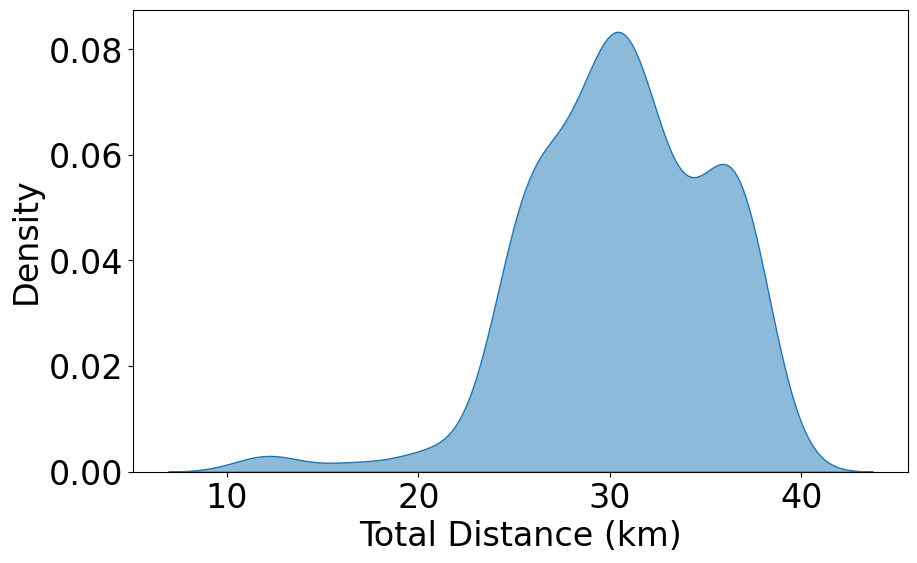

In [6]:
# Remove duplicate rows based on the subset of columns
plt.figure(figsize=(10, 6))
plt.rcParams.update({"font.size": 24})

# Plot KDE for each company with custom legends
sns.kdeplot(
    data=enriched_trajectories_df,
    x="total_distance",
    fill=True,
    common_norm=False,
    alpha=0.5,
)

plt.xlabel("Total Distance (km)")
plt.ylabel("Density")
# plt.legend()#title="Companies")
save_plot("Anglova_kde")
plt.show()

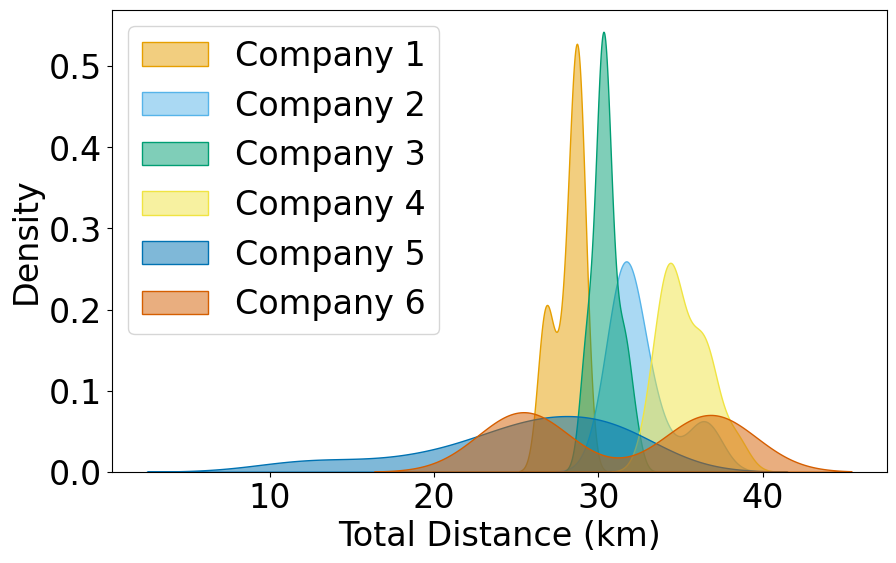

In [86]:
# Remove duplicate rows based on the subset of columns
plt.figure(figsize=(10, 6))
plt.rcParams.update({"font.size": 24})

# Plot KDE for each company with custom legends
for i in enriched_trajectories_df["Company"].unique():
    sns.kdeplot(
        data=enriched_trajectories_df[enriched_trajectories_df["Company"] == i],
        x="total_distance",
        fill=True,
        common_norm=False,
        alpha=0.5,
        label=f"Company {i}",
    )

plt.xlabel("Total Distance (km)")
plt.ylabel("Density")
plt.legend()#title="Companies")
save_plot("Company_kde")
plt.show()

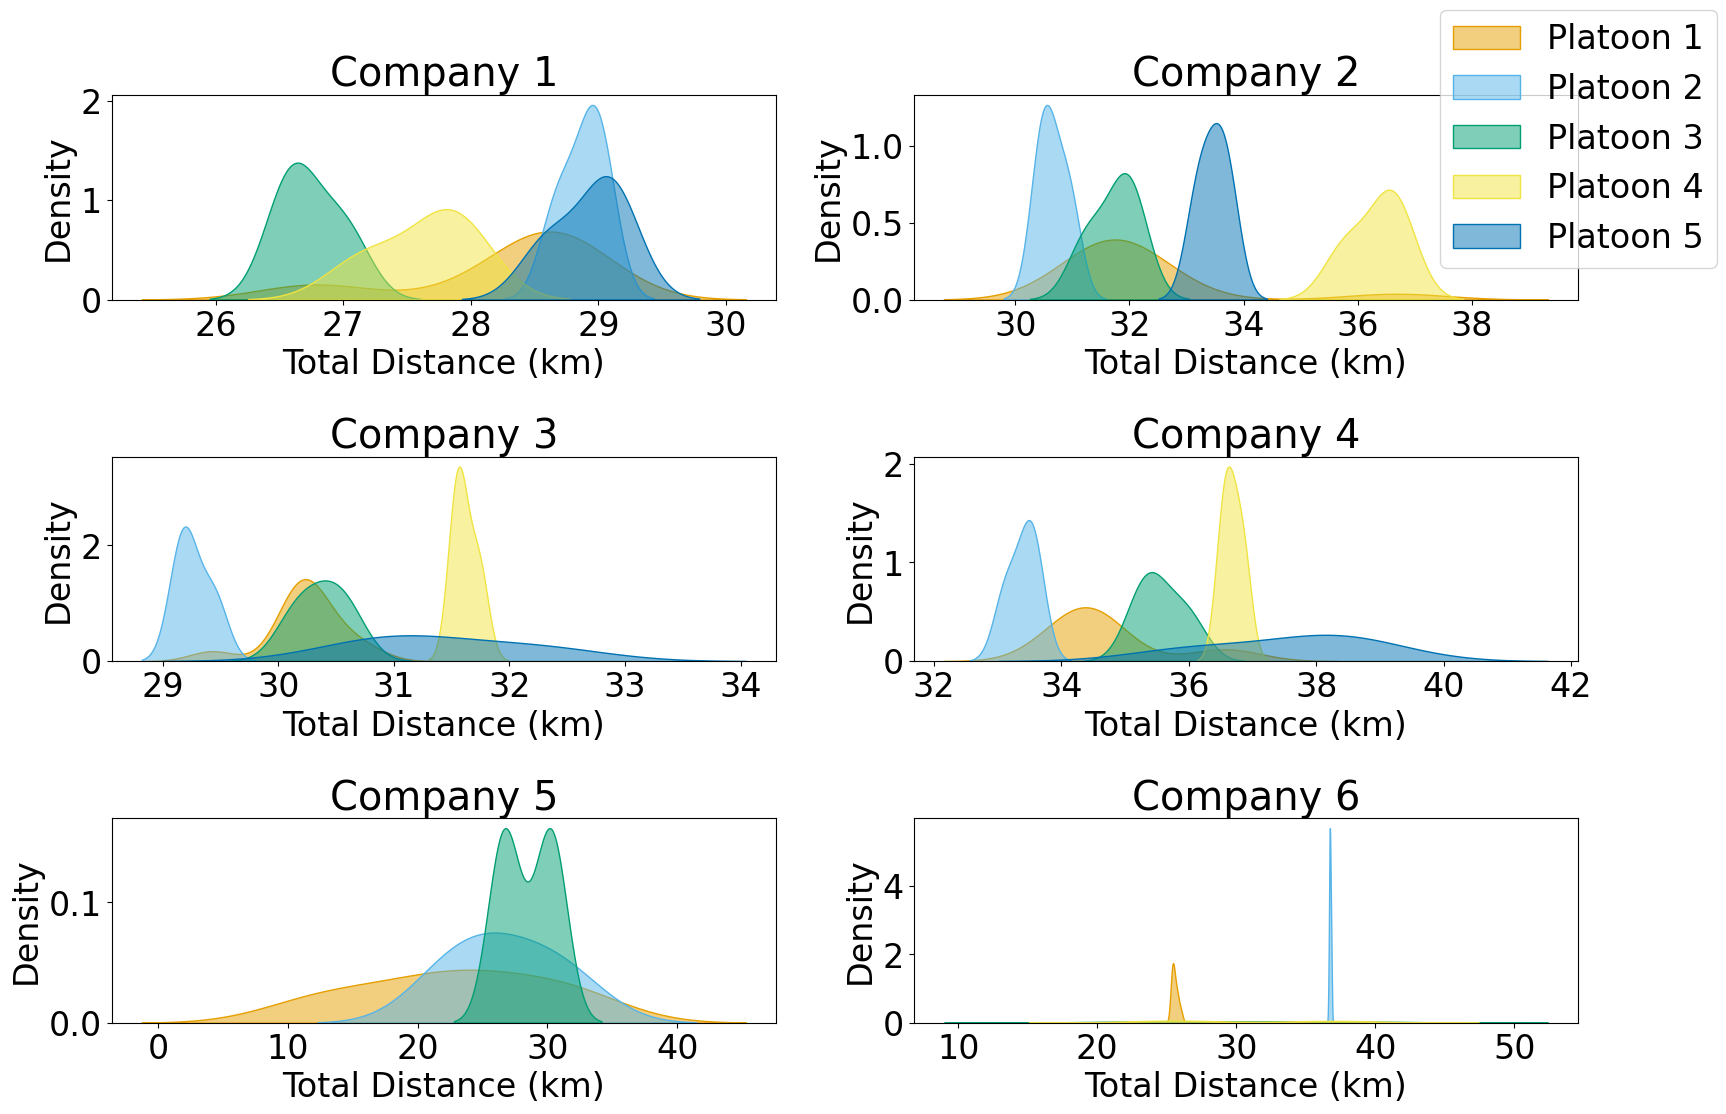

In [87]:
# Define grid dimensions
n, m = 3,2   # 3x3 grid

# Get unique companies
unique_companies = enriched_trajectories_df["Company"].unique()

# Create subplots
fig, axes = plt.subplots(n, m, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot KDE for each company
sns.set_palette(cud_okabe_ito_colors)
for idx, company in enumerate(unique_companies):
    company_data = enriched_trajectories_df[enriched_trajectories_df["Company"] == company]
    for i in company_data["Platoon"].unique():
        sns.kdeplot(
            ax=axes[idx],
            data=company_data[company_data["Platoon"] == i],
            x="total_distance",
            fill=True,
            common_norm=True,
            alpha=0.5,
            label=f"Platoon {i}",
        )
    axes[idx].set_title(f"Company {company}")
    axes[idx].set_xlabel("Total Distance (km)")
    axes[idx].set_ylabel("Density")
    if idx == 1:
        axes[idx].legend(loc='upper center', bbox_to_anchor=(1, 1.5), fontsize=24)

# Hide unused subplots
for ax in axes[len(unique_companies):]:
    ax.axis("off")

plt.tight_layout()
save_plot("Company_vs_Platoon_kde")
plt.show()


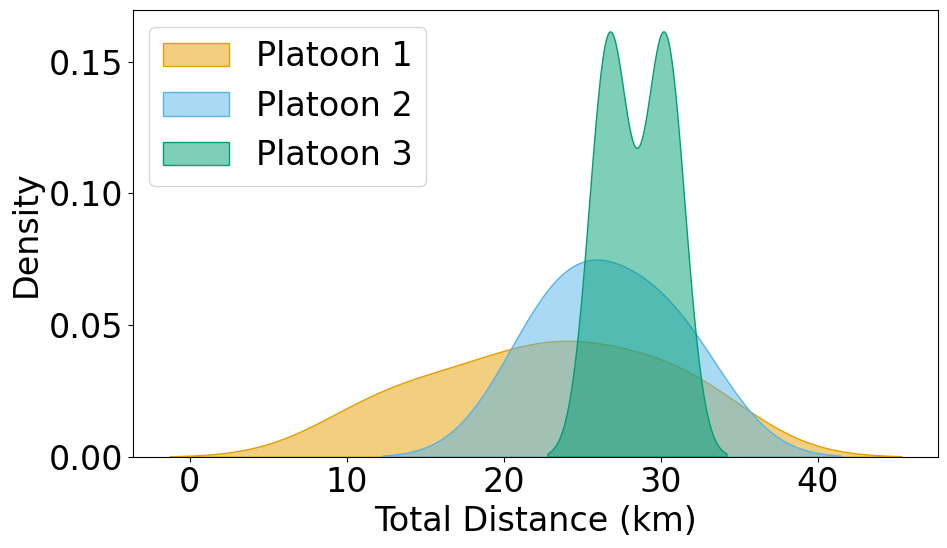

In [134]:
# Filter data for Company 5
company_5_data = enriched_trajectories_df[enriched_trajectories_df["Company"] == 5]

# Get unique platoons for Company 5
unique_platoons = company_5_data["Platoon"].unique()

# Create a single plot
plt.figure(figsize=(10, 6))

# Plot KDE for each platoon in Company 5
sns.set_palette(cud_okabe_ito_colors)
for platoon in unique_platoons:
    platoon_data = company_5_data[company_5_data["Platoon"] == platoon]
    sns.kdeplot(
        data=platoon_data,
        x="total_distance",
        fill=True,
        common_norm=True,
        alpha=0.5,
        label=f"Platoon {platoon}",
    )

# plt.title("Company 5 - Total Distance Distribution by Platoon")
plt.xlabel("Total Distance (km)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
save_plot("Company1_Platoon_kde")
plt.show()


In [102]:
company_1_platoon_1_data = enriched_trajectories_df[
    (enriched_trajectories_df["Company"] == 5) & 
    (enriched_trajectories_df["Platoon"] == 1)
]

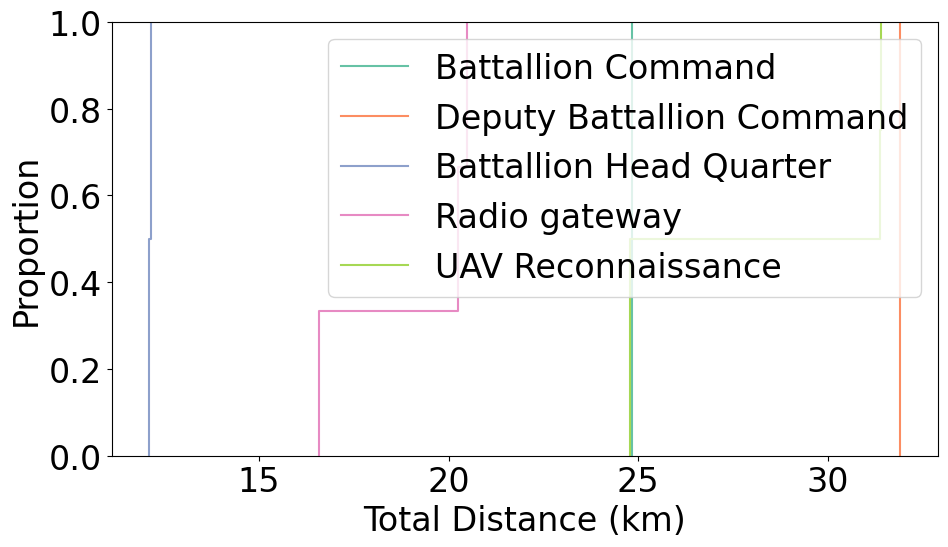

In [ ]:
# Create a KDE plot with hue as Vehicle Function
plt.figure(figsize=(10, 6))

# Plot KDE for each platoon in Company 5
sns.set_palette("Set2")
for platoon in company_1_platoon_1_data['Vehicle Function'].unique():
    platoon_data = company_5_data[company_5_data["Vehicle Function"] == platoon]
    sns.ecdfplot(
        data=platoon_data,
        x="total_distance",
        label=f"{platoon}",
    )


plt.xlabel("Total Distance (km)")
# plt.ylabel("Density")
plt.legend(loc='upper right', fontsize=24)
plt.tight_layout()
save_plot("Company1_Platoon1_VehicleFunction_kde")
plt.show()

In [246]:
filtered_data = company_1_platoon_1_data[
    company_1_platoon_1_data['Vehicle Function'].isin(["Battallion Head Quarter", "Radio gateway "])
]

C:\Users\edgar\AppData\Local\Temp\ipykernel_13848\1162402307.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(
C:\Users\edgar\AppData\Local\Temp\ipykernel_13848\1162402307.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=8)


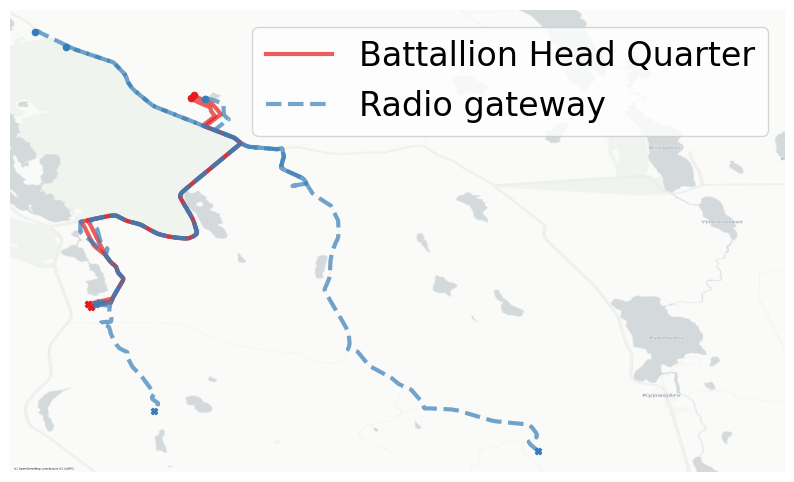

In [254]:
import geopandas as gpd
from matplotlib import cm

category = "Vehicle Function"
df = enriched_points[enriched_points["trajectory_id"].isin(filtered_data['trajectory_id'])]
# Ordena por id e tempo
df = df.sort_values(by=["trajectory_id", "t"])

# Converte para GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

# Obtém os limites do GeoDataFrame (em EPSG:3857)
bbox = gdf.total_bounds  # [minx, miny, maxx, maxy]

# Calcula a margem (5% do tamanho em cada eixo)
margin_x = (bbox[2] - bbox[0]) * 0.05
margin_y = (bbox[3] - bbox[1]) * 0.05

# Aplica a margem aos limites
minx = bbox[0] - margin_x
maxx = bbox[2] + margin_x
miny = bbox[1] - margin_y
maxy = bbox[3] + margin_y

# Pega categorias únicas e define um mapa de cores
categorias = sorted(gdf[category].unique())
cmap = cm.get_cmap(
    "tab10", len(categorias)
)  # você pode trocar por "Set1", "Paired" etc.

# Cria um plot agregado antes de todos os outros
fig, ax = plt.subplots(figsize=(10, 6))
ax.legend(loc="upper right", fontsize=8)
for _, traj in gdf.groupby("trajectory_id"):
    color = sns.color_palette("Set1", len(categorias))[categorias.index(traj[category].iloc[0]) % len(categorias)]
    line_styles = ["-", "--", "-.", ":", (0, (3, 5, 1, 5)), (0, (5, 10))]
    line_style = line_styles[categorias.index(traj[category].iloc[0]) % len(line_styles)]
    ax.plot(
        traj.geometry.x,
        traj.geometry.y,
        line_style,
        color=color,
        linewidth=3,
        alpha=0.7,
        label=traj[category].iloc[0],  # Add legend for each trajectory
    )
    start_point = traj.groupby("trajectory_id").first()
    end_point = traj.groupby("trajectory_id").last()
    ax.scatter(
        start_point.geometry.x,
        start_point.geometry.y,
        color=color,
        marker="o",
        s=20,
        zorder=3,
    )
    ax.scatter(
        end_point.geometry.x,
        end_point.geometry.y,
        color=color,
        marker="X",
        s=20,
        zorder=3,
    )
# ax.set_title(f"{category}", fontsize=16)
ax.legend()
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize=24)
ax.axis("off")
# Extend the bounding box of the plot
ax.set_xlim(
    ax.get_xlim()[0],
    ax.get_xlim()[1] + 0.4 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
)
ax.set_ylim(
    ax.get_ylim()[0],
    ax.get_ylim()[1] + 0 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
)
ctx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    attribution_size=2,
)
save_plot("BattallionHeadQuarter_RadioGateway_spatial")
plt.show()
